# SkimLit Model

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're repilicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251


In [ ]:
!wget https://github.com/Franck-Dernoncourt/pubmed-rct.git

--2023-05-06 20:29:02--  https://github.com/Franck-Dernoncourt/pubmed-rct.git
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/Franck-Dernoncourt/pubmed-rct [following]
--2023-05-06 20:29:02--  https://github.com/Franck-Dernoncourt/pubmed-rct
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pubmed-rct.git’

pubmed-rct.git          [ <=>                ] 181.81K  --.-KB/s    in 0.1s    

2023-05-06 20:29:03 (1.73 MB/s) - ‘pubmed-rct.git’ saved [186176]

--2023-05-06 20:29:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw

## Get data

Since we will be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 4.57 MiB/s, done.
Updating files: 100% (13/13), done.


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_hub as hub
from keras.utils import plot_model

from helper_functions import calculate_results, create_tensorboard_callback, plot_loss_curves, make_confusion_matrix

In [ ]:
# Start our experiments using 20K dataset with numbers replaced by "@" sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

SAVE_DIR = 'skimlit_experiment'

In [ ]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

Now we have got some text data, it is time to become one with it.

And one of the best ways to become one with the data is to ...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.


In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and return the lines of text as a list.

  Args:
    filename: a string contraining the target filepath.

  Returns:
    A list of string with one string per line from the target filename.
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

# Let's think about how we want our data to look...

How I think our data would be best represented...

`[{'line_number': 0, 
  'target': 'BACKGROUND',
  'text': 'Yet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal .\n'
  'total_lines': 11},
   ...]`

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is
  """
  # get all lines from filename
  input_lines = get_lines(filename)

  # create an empty abstract
  abstract_lines = ''

  # create an empty list of abstracts
  abstract_samples = []

  # Loop through each line in the target file
  for line in input_lines:
    # Check to see if the line is ID line
    if line.startswith('###'):
      abstract_id = line
      # reset abstract lines
      abstract_lines = ""
    elif line.isspace():  # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}  # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in abstract
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract
        abstract_samples.append(line_data)
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

CPU times: user 468 ms, sys: 175 ms, total: 643 ms
Wall time: 651 ms


In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
test_df.head(10)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts(normalize=True) * 100

METHODS        32.966563
RESULTS        32.188958
CONCLUSIONS    15.089980
BACKGROUND     12.067874
OBJECTIVE       7.686625
Name: target, dtype: float64

<Axes: ylabel='Frequency'>

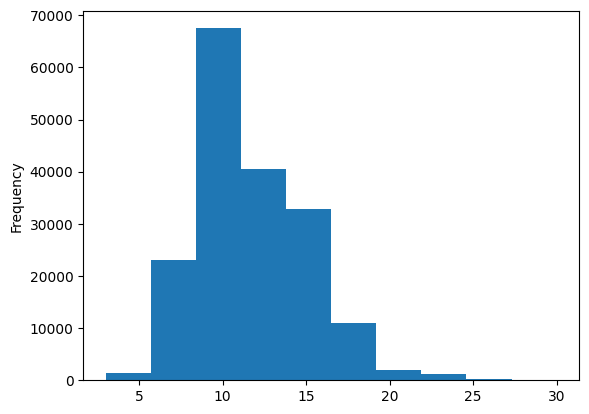

In [ ]:
# Let's check the lenth of different lines
train_df.total_lines.plot.hist()

## Get list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

## Make numberic labels

In [ ]:
# One hot encode labels
ohe = OneHotEncoder(sparse=False)
train_labels_ohe = ohe.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_ohe = ohe.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_ohe = ohe.transform(test_df['target'].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Extract labels (target) columns and encode them into integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
# Get class names and number of classes from LabelEncoder Instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0: Baseline model Naive Bayes with Tfidf Vectorizer

In [ ]:
# Build model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit
model_0.fit(
    train_sentences, train_labels_encoded
)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Train accuracy
model_0.score(train_sentences, train_labels_encoded)

0.7516829593423684

In [ ]:
# Validation accuracy
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)

In [ ]:
# Calculate results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

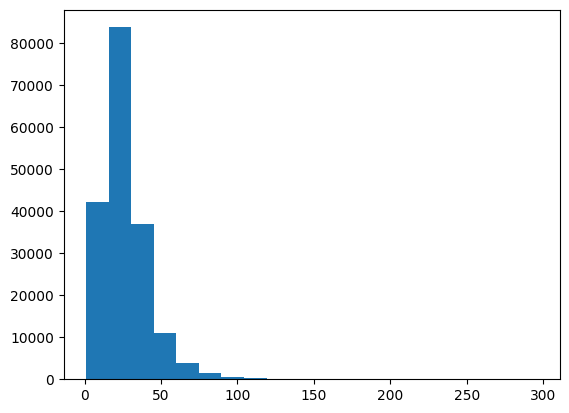

In [ ]:
# What's the distribution look like?
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Create text vectorization
max_features = 68_000

text_vec = TextVectorization(
    max_tokens=output_seq_len,
    output_sequence_length=output_seq_len
)

In [ ]:
# Adapt text vectorizer to training sentences
text_vec.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"Length:\n{len(target_sentence)}")
print(f"Vectorized Text:\n{text_vec([target_sentence])}")


Text:
the aim of this study is to determine if treatment with melatonin improves post-concussion syndrome in youths following mild traumatic brain injury .
Length:
149
Vectorized Text:
[[ 2  1  4 23 17 20  6  1  1 19  7  1  1  1  1  5  1  1  1  1  1  1  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vec.get_vocabulary()
len(rct_20k_text_vocab)


55

In [ ]:
rct_20k_text_vocab[:5]

['', '[UNK]', 'the', 'and', 'of']

In [ ]:
rct_20k_text_vocab[-5:]

['ci', 'two', 'during', 'weeks', 'both']

In [ ]:
# Create token embedding layer
embedding = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name='token_embedding'
)

## Creating datasets (making sure our data loads as fast as possible)

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_ohe))
test_dataset =  tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_ohe))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: Conv1D with token embedding

In [ ]:
# Build Conv1D model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(inputs)
x = embedding(x)
x = layers.Conv1D(32, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_conv1d_embed')

# Compile
model_1.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

In [ ]:
model_1.summary()

Model: "model_1_conv1d_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          7040      
                                                                 
 conv1d (Conv1D)             (None, 51, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)        

In [ ]:
# Fit
model_1_history = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
    epochs=5,
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, 'model_1_conv1d_embed')
    ]
)

Saving TensorBoard log files to: skimlit_experiment/model_1_conv1d_embed/20230506-203218
Epoch 1/5
5627/5627 [==============================] - 117s 20ms/step - loss: 0.8752 - accuracy: 0.6509 - val_loss: 0.8024 - val_accuracy: 0.6878
Epoch 2/5
5627/5627 [==============================] - 104s 19ms/step - loss: 0.8078 - accuracy: 0.6796 - val_loss: 0.7843 - val_accuracy: 0.6902
Epoch 3/5
5627/5627 [==============================] - 111s 20ms/step - loss: 0.7937 - accuracy: 0.6852 - val_loss: 0.7782 - val_accuracy: 0.6945
Epoch 4/5
5627/5627 [==============================] - 124s 22ms/step - loss: 0.7853 - accuracy: 0.6895 - val_loss: 0.7722 - val_accuracy: 0.6951
Epoch 5/5
5627/5627 [==============================] - 128s 23ms/step - loss: 0.7798 - accuracy: 0.6922 - val_loss: 0.7696 - val_accuracy: 0.6938


In [ ]:
# Make prediction
model_1_pred_probs = model_1.predict(val_sentences)

945/945 [==============================] - 9s 9ms/step


In [ ]:
# Convert predictions to labels
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
# Calculate results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results


{'accuracy': 69.35323712432147,
 'precision': 0.6920314987134688,
 'recall': 0.6935323712432147,
 'f1': 0.6879263181189689}

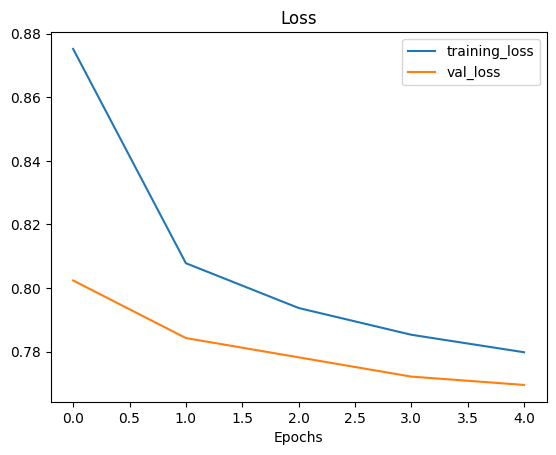

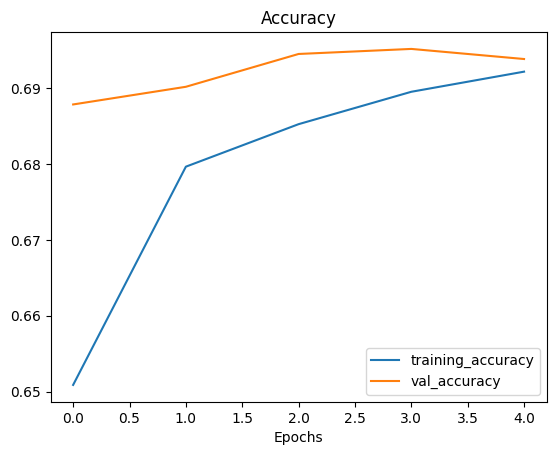

In [ ]:
# Plot loss curves
plot_loss_curves(model_1_history)

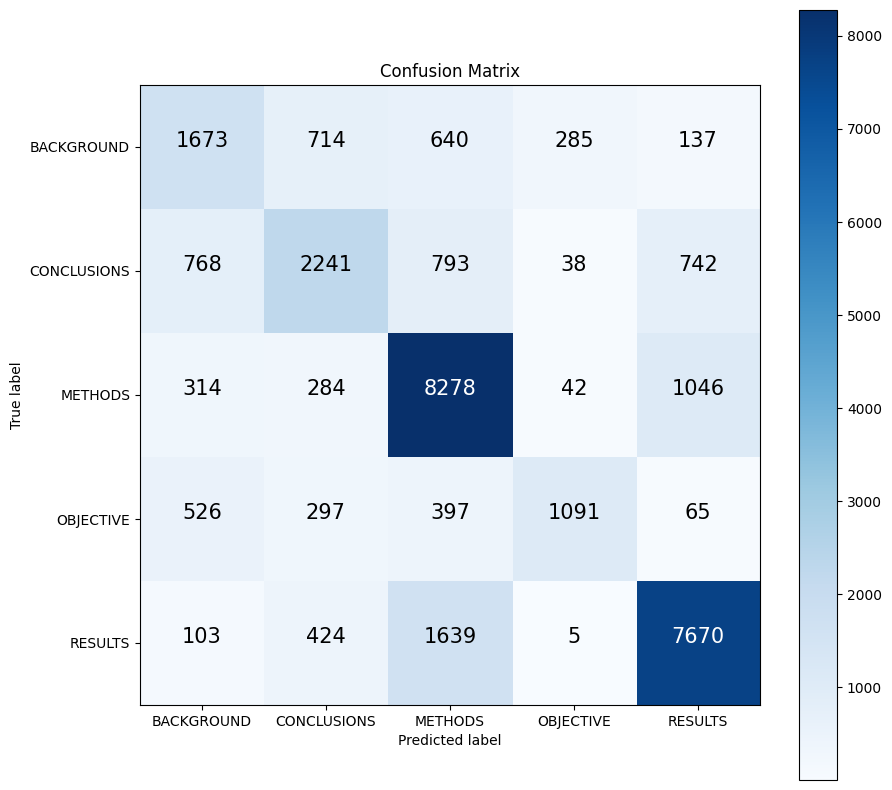

In [ ]:
# Make confusion matrix
make_confusion_matrix(val_labels_encoded, model_1_preds, classes=class_names.tolist())

## Model 2: TensorFlow Hub Pretrained Feature Extractor

In [ ]:
tf_hub_embedding_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False,
    name='USE_layer'
)

In [ ]:
# Build model
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_use_pretrained')

# compile
model_2.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

In [ ]:
# Fit
model_2_history = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
    epochs=5,
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, 'model_2_use_pretrained')
    ]
)

Saving TensorBoard log files to: skimlit_experiment/model_2_use_pretrained/20230506-204418
Epoch 1/5
5627/5627 [==============================] - 126s 21ms/step - loss: 0.7290 - accuracy: 0.7210 - val_loss: 0.6491 - val_accuracy: 0.7586
Epoch 2/5
5627/5627 [==============================] - 109s 19ms/step - loss: 0.6330 - accuracy: 0.7599 - val_loss: 0.6147 - val_accuracy: 0.7683
Epoch 3/5
5627/5627 [==============================] - 122s 22ms/step - loss: 0.5992 - accuracy: 0.7726 - val_loss: 0.6009 - val_accuracy: 0.7719
Epoch 4/5
5627/5627 [==============================] - 115s 20ms/step - loss: 0.5774 - accuracy: 0.7817 - val_loss: 0.5952 - val_accuracy: 0.7729
Epoch 5/5
5627/5627 [==============================] - 144s 26ms/step - loss: 0.5612 - accuracy: 0.7882 - val_loss: 0.5943 - val_accuracy: 0.7746


In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(val_sentences)

# Convert to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

# Calculate results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

945/945 [==============================] - 16s 16ms/step


{'accuracy': 77.31034026214749,
 'precision': 0.7712982644772077,
 'recall': 0.7731034026214749,
 'f1': 0.7693100097724827}

## Model 3: Conv1D with character embeddings

The paper which we're replicating said they used a combination of token and character level embeddings.

### Creating a character level tokenizer


In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

# Text splitting non-character level sequence into cahracters
split_chars(train_sentences[0])

In [ ]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

149.3662574983337

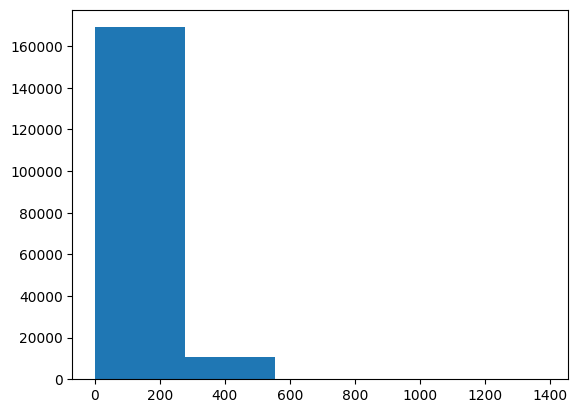

In [ ]:
# Check distribution of number of characters
plt.hist(char_lens, bins=5);

In [ ]:
# Find what character length covers 95% of sequences 
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char level token vecotrizer instance
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(
                      max_tokens=NUM_CHAR_TOKENS,
                      output_sequence_length=output_seq_char_len,
                      name='char_vectorizer',
                      # standardize=None,
                  )


In [ ]:
# Adapt character vecotrizer to training character
char_vectorizer.adapt(train_chars)


In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [ ]:
# Test out character vecotizer
random_train_chars = random.choice(train_chars)
random_train_chars, len(random_train_chars.split()), char_vectorizer([random_train_chars])

('t h e   a i m   o f   t h i s   r a n d o m i s e d   c o n t r o l l e d   t r i a l   (   r c t   )   i s   t o   d e t e r m i n e   i f   t h e   a d d i t i o n   o f   t r i c l o s a n   c o a t e d   s u t u r e s   t o   a   s t a n d a r d   r e g i m e n   c a n   r e d u c e   t h e   r a t e   o f   s s i   a f t e r   t o t a l   k n e e   r e p l a c e m e n t   (   t k r   )   a n d   t o t a l   h i p   r e p l a c e m e n t   (   t h r   )   .',
 189,
 <tf.Tensor: shape=(1, 290), dtype=int64, numpy=
 array([[ 3, 13,  2,  5,  4, 15,  7, 17,  3, 13,  4,  9,  8,  5,  6, 10,
          7, 15,  4,  9,  2, 10, 11,  7,  6,  3,  8,  7, 12, 12,  2, 10,
          3,  8,  4,  5, 12,  8, 11,  3,  4,  9,  3,  7, 10,  2,  3,  2,
          8, 15,  4,  6,  2,  4, 17,  3, 13,  2,  5, 10, 10,  4,  3,  4,
          7,  6,  7, 17,  3,  8,  4, 11, 12,  7,  9,  5,  6, 11,  7,  5,
          3,  2, 10,  9, 16,  3, 16,  8,  2,  9,  3,  7,  5,  9,  3,  5,
          6, 10,  5,  8, 10,  8,  2, 

In [ ]:
# Create token embedding layer
char_embedding = layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,  # this is the size of the char embedding in the paper
    mask_zero=True,
    name='char_embedding'
)

In [ ]:
# Test out character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n{char_embed_example}")
char_embed_example.shape

Charified text:
 t h e   a i m   o f   t h i s   r a n d o m i s e d   c o n t r o l l e d   t r i a l   (   r c t   )   i s   t o   d e t e r m i n e   i f   t h e   a d d i t i o n   o f   t r i c l o s a n   c o a t e d   s u t u r e s   t o   a   s t a n d a r d   r e g i m e n   c a n   r e d u c e   t h e   r a t e   o f   s s i   a f t e r   t o t a l   k n e e   r e p l a c e m e n t   (   t k r   )   a n d   t o t a l   h i p   r e p l a c e m e n t   (   t h r   )   .
Embedded chars. (after vectorization and embedding):
[[[-0.03467548 -0.03507764 -0.00997878 ...  0.00051335  0.04337977
   -0.0313008 ]
  [-0.010568   -0.01039619 -0.01099316 ...  0.00988202  0.03344914
    0.04765285]
  [-0.02926598 -0.03661076 -0.02506422 ...  0.02127622  0.00682318
    0.04894624]
  ...
  [ 0.04996547 -0.02768889  0.01671198 ... -0.03848221 -0.00727404
    0.02766831]
  [ 0.04996547 -0.02768889  0.01671198 ... -0.03848221 -0.00727404
    0.02766831]
  [ 0.04996547 -0.02768889  0.01671198 ... 

TensorShape([1, 290, 25])

In [ ]:
# Build conv1d with character embedding model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(32, 5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d_with_char_embed')

# Compile
model_3.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

In [ ]:
model_3.summary()

Model: "model_3_conv1d_with_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 286, 32)           4032      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 

In [ ]:
# Fit
model_3_history = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
    epochs=5,
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, 'model_3_conv1d_with_char_embed')
    ]
)

Saving TensorBoard log files to: skimlit_experiment/model_3_conv1d_with_char_embed/20230506-211845
Epoch 1/5
5627/5627 [==============================] - 175s 31ms/step - loss: 1.3218 - accuracy: 0.4369 - val_loss: 1.3153 - val_accuracy: 0.4438
Epoch 2/5
5627/5627 [==============================] - 132s 24ms/step - loss: 1.3076 - accuracy: 0.4420 - val_loss: 1.3112 - val_accuracy: 0.4448
Epoch 3/5
5627/5627 [==============================] - 127s 23ms/step - loss: 1.3046 - accuracy: 0.4422 - val_loss: 1.3100 - val_accuracy: 0.4445
Epoch 4/5
5627/5627 [==============================] - 127s 23ms/step - loss: 1.3034 - accuracy: 0.4424 - val_loss: 1.3098 - val_accuracy: 0.4441
Epoch 5/5
5627/5627 [==============================] - 131s 23ms/step - loss: 1.3024 - accuracy: 0.4422 - val_loss: 1.3093 - val_accuracy: 0.4445


In [ ]:
# Make prediction
model_3_pred_probs = model_3.predict(val_sentences) 

# Convert to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

# Calculate results
model_3_results = calculate_results(val_labels_encoded, model_3_preds.numpy())
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.73388057725407,
 'precision': 0.5019244987412128,
 'recall': 0.4473388057725407,
 'f1': 0.3638334666308683}

## Model 4: Pretrained token embedding (same as 2) + character embeddings (same as 3)

In [ ]:
# Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(300, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm_outputs = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm_outputs)

# Combine inputs
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# Create output layers - adding in Dropout
combine_dropout = layers.Dropout(.5)(token_char_concat)
combine_reshaped = tf.expand_dims(combine_dropout, axis=1)
combine_dense = layers.Bidirectional(layers.LSTM(24))(combine_reshaped)
# combine_dense = layers.Dense(128, activation='relu')(combine_dropout)
final_dropout = layers.Dropout(.1)(combine_dense)
output_layer = layers.Dense(len(class_names), activation='softmax')(final_dropout)

# Construct model
model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name='model_4_token_and_char_embeddings'
)

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE_layer (KerasLayer)         (None, 512)          256797824   [

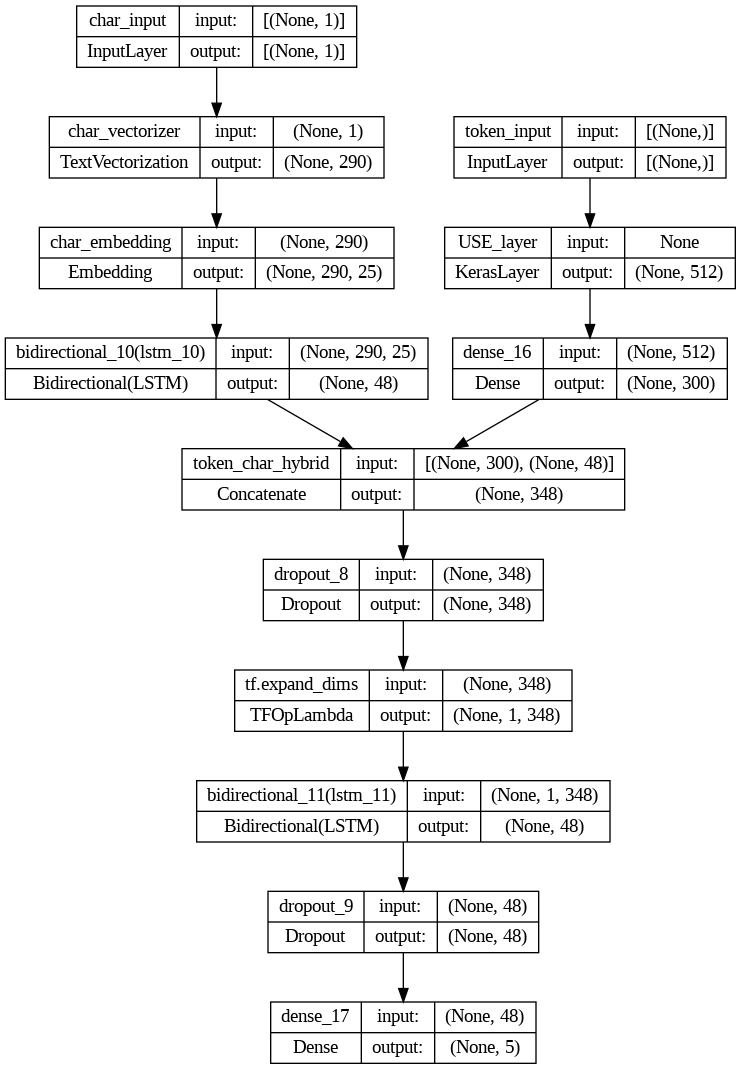

In [ ]:
# Plot hybrid model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile
model_4.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_ohe)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Combine chars and tokens into a dataset
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_ohe)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

# Prefetch and batch val data
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_token_char_dataset, val_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit
model_4_history = model_4.fit(
    train_token_char_dataset,
    validation_data=val_token_char_dataset,
    steps_per_epoch=int(.1*len(train_token_char_dataset)),
    validation_steps=int(.1*len(val_token_char_dataset)),
    epochs=5,
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, 'model_4_token_and_char_embeddings')
    ]
)

Saving TensorBoard log files to: skimlit_experiment/model_4_token_and_char_embeddings/20230506-221556
Epoch 1/5
562/562 [==============================] - 352s 575ms/step - loss: 0.9194 - accuracy: 0.6392 - val_loss: 0.7674 - val_accuracy: 0.7048
Epoch 2/5
562/562 [==============================] - 248s 441ms/step - loss: 0.7646 - accuracy: 0.7027 - val_loss: 0.7130 - val_accuracy: 0.7267
Epoch 3/5
562/562 [==============================] - 244s 435ms/step - loss: 0.7402 - accuracy: 0.7119 - val_loss: 0.6824 - val_accuracy: 0.7417
Epoch 4/5
562/562 [==============================] - 235s 418ms/step - loss: 0.7057 - accuracy: 0.7308 - val_loss: 0.6554 - val_accuracy: 0.7517
Epoch 5/5
562/562 [==============================] - 319s 568ms/step - loss: 0.7071 - accuracy: 0.7305 - val_loss: 0.6372 - val_accuracy: 0.7540


In [ ]:
# Evaluate on all validation dataset
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 115s 121ms/step - loss: 0.6456 - accuracy: 0.7521


[0.6455877423286438, 0.7520521879196167]

In [ ]:
# Make prediction
model_4_pred_probs = model_4.predict(val_token_char_dataset)

# Convert to labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

# Calculate results
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 75.20521647027671,
 'precision': 0.7481902799317214,
 'recall': 0.7520521647027671,
 'f1': 0.7472899610082667}

## Model 5: Tribridg Embedding -> Pretrained token embedding + character embedding + positional embeddings

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts(normalize=True)

0     0.083315
1     0.083315
2     0.083315
3     0.083315
4     0.083270
5     0.083032
6     0.081971
7     0.079310
8     0.074128
9     0.066546
10    0.055771
11    0.043835
12    0.032509
13    0.023062
14    0.015747
15    0.010337
16    0.006599
17    0.004171
18    0.002566
19    0.001589
20    0.000900
21    0.000561
22    0.000367
23    0.000183
24    0.000122
25    0.000078
26    0.000039
27    0.000022
28    0.000017
29    0.000006
30    0.000006
Name: line_number, dtype: float64

<Axes: ylabel='Frequency'>

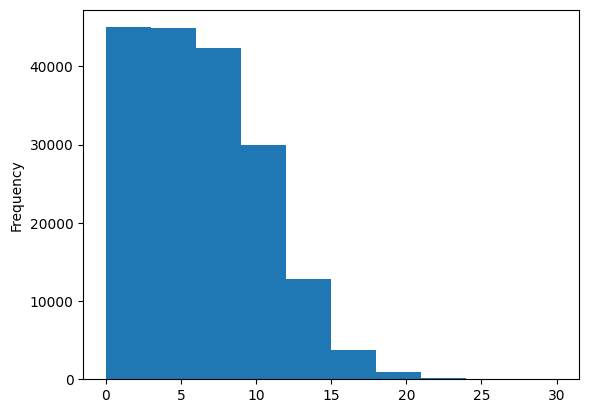

In [ ]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoder for line_number column
train_line_numbers_ohe = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_ohe = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_ohe = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_ohe[:1], train_line_numbers_ohe.shape

(<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# How many different total_lines are there?
train_df['total_lines'].value_counts(normalize=True)

11    0.135903
10    0.131299
12    0.122823
9     0.107754
13    0.102411
14    0.081149
8     0.068235
15    0.059809
7     0.041457
16    0.041263
17    0.028894
6     0.018624
18    0.018574
19    0.013775
20    0.007115
5     0.006365
21    0.004277
22    0.004216
23    0.001466
4     0.001194
24    0.001111
25    0.001011
26    0.000450
28    0.000322
3     0.000178
30    0.000172
27    0.000156
Name: total_lines, dtype: float64

<Axes: ylabel='Frequency'>

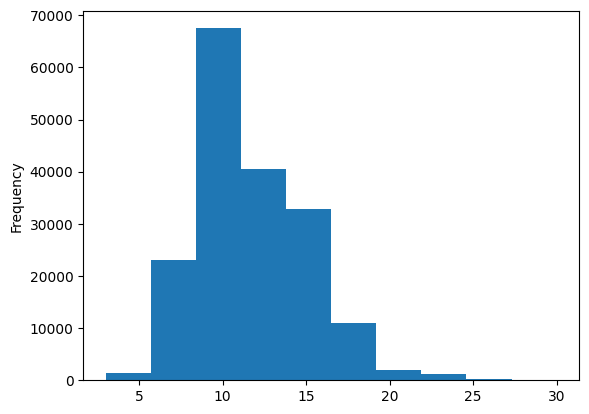

In [ ]:
# Check the distribution of 'total_lines' column
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoder for line_number column
train_total_lines_ohe = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_ohe = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_ohe = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_ohe[:1], train_total_lines_ohe.shape

(<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

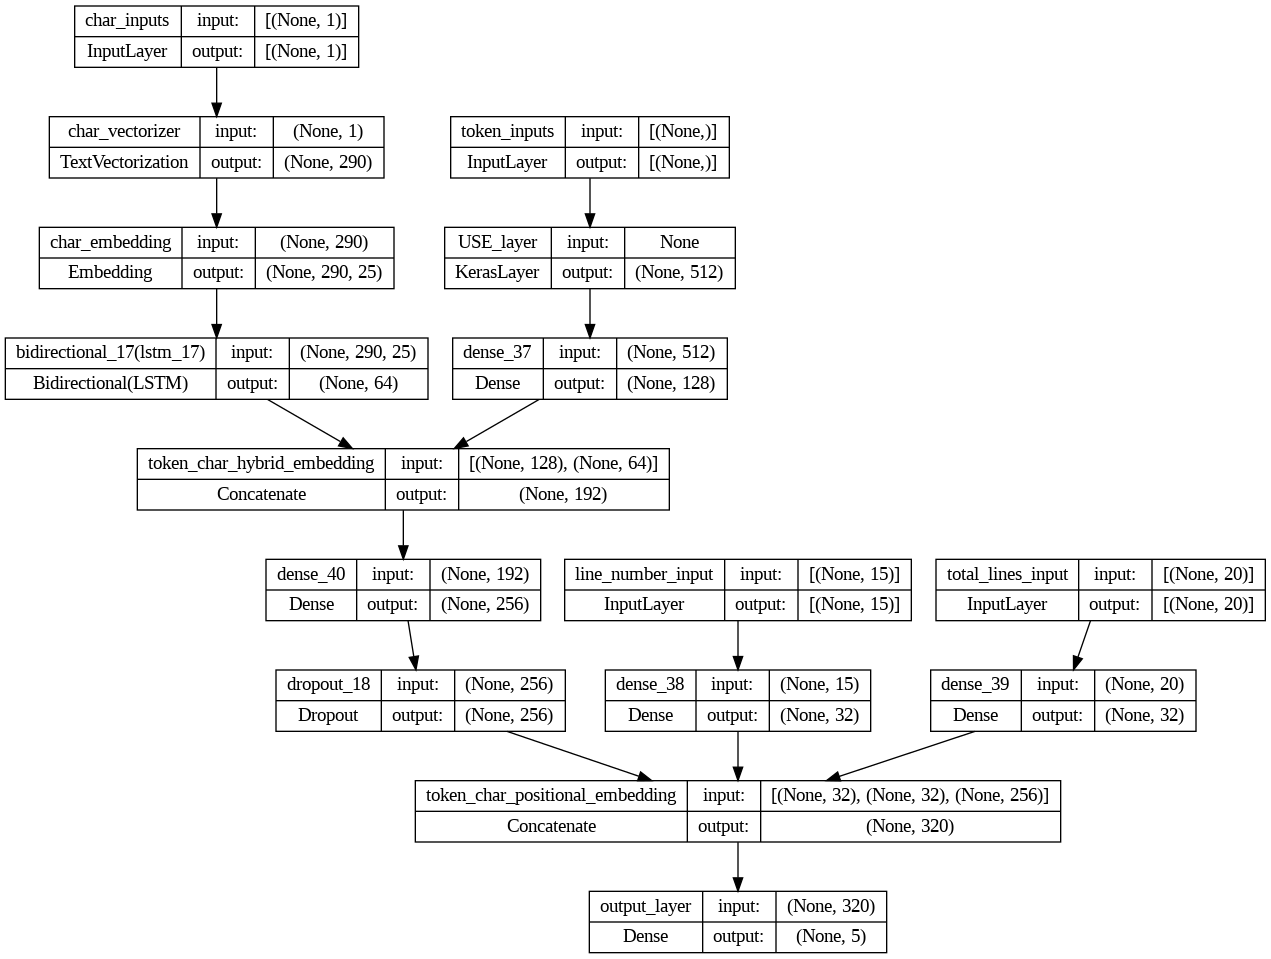

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile
model_5.compile(
    loss=CategoricalCrossentropy(label_smoothing=.2),
    optimizer=Adam(),
    metrics=['accuracy']
)

### Create dataset for model

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_ohe, # line numbers
                                                                train_total_lines_ohe, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_ohe) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_ohe,
                                                              val_total_lines_ohe,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_ohe)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit
model_5_history = model_5.fit(
    train_pos_char_token_dataset,
    validation_data=val_pos_char_token_dataset,
    validation_steps=int(.1*len(val_pos_char_token_dataset)),
    steps_per_epoch=int(.1*len(train_pos_char_token_dataset)),
    epochs=5,
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, 'model_5_tribrid_embeddings')
    ]
)

Saving TensorBoard log files to: skimlit_experiment/model_5_tribrid_embeddings/20230506-232520
Epoch 1/5
562/562 [==============================] - 301s 460ms/step - loss: 1.0901 - accuracy: 0.7291 - val_loss: 0.9811 - val_accuracy: 0.8068
Epoch 2/5
562/562 [==============================] - 249s 444ms/step - loss: 0.9684 - accuracy: 0.8148 - val_loss: 0.9502 - val_accuracy: 0.8291
Epoch 3/5
562/562 [==============================] - 255s 453ms/step - loss: 0.9519 - accuracy: 0.8227 - val_loss: 0.9395 - val_accuracy: 0.8305
Epoch 4/5
562/562 [==============================] - 326s 580ms/step - loss: 0.9418 - accuracy: 0.8318 - val_loss: 0.9274 - val_accuracy: 0.8374
Epoch 5/5
562/562 [==============================] - 316s 562ms/step - loss: 0.9369 - accuracy: 0.8370 - val_loss: 0.9225 - val_accuracy: 0.8391


In [ ]:
# Evaluate on full val dataset
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 95s 101ms/step - loss: 0.9219 - accuracy: 0.8414


[0.9218572974205017, 0.8413544297218323]

In [ ]:
# Make prediction
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)

# Convert to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

# Calculate results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

945/945 [==============================] - 118s 117ms/step


{'accuracy': 84.13544287038263,
 'precision': 0.8444322091208325,
 'recall': 0.8413544287038263,
 'f1': 0.8375975552642815}

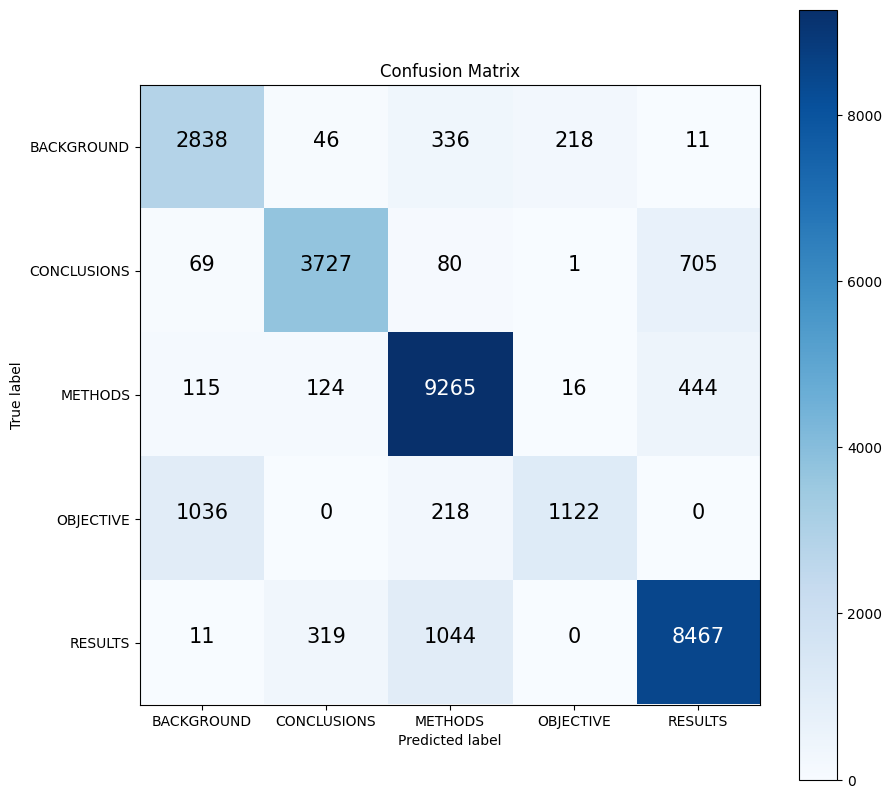

In [ ]:
make_confusion_matrix(val_labels_encoded, model_5_preds, class_names.tolist(), savefig=True)

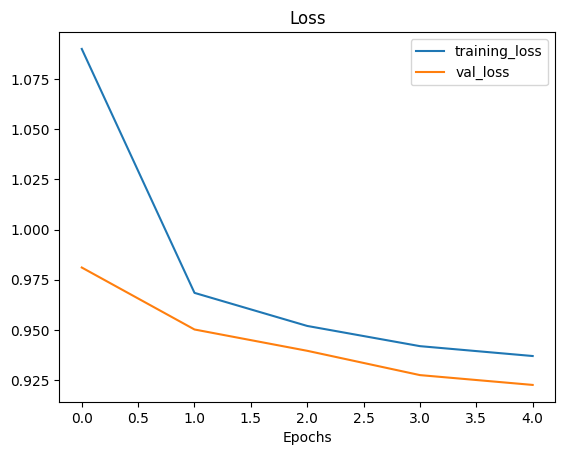

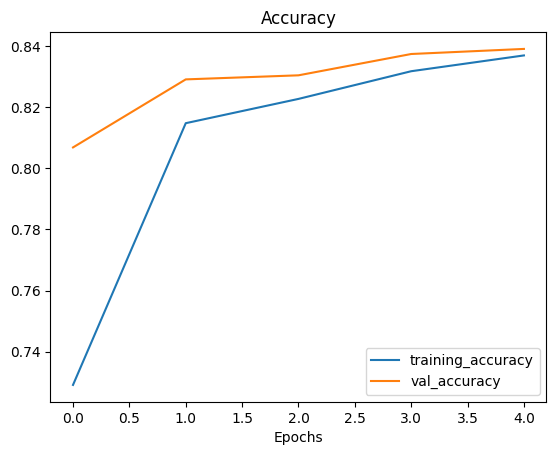

In [ ]:
plot_loss_curves(model_5_history)

In [ ]:
model_5.save('/content/drive/MyDrive/datasets/SkimLit/model/skimlit_tribrid_model')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/datasets/SkimLit/model/skimlit_tribrid_model')

In [ ]:
loaded_model.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 100s 106ms/step - loss: 0.9219 - accuracy: 0.8414


[0.9218572974205017, 0.8413544297218323]

In [ ]:
!cp '/content/model.png' '/content/drive/MyDrive/datasets/SkimLit/metrics/model_structure.png'

In [ ]:
!cp '/content/confusion_matrix.png' '/content/drive/MyDrive/datasets/SkimLit/metrics/confusion_matrix.png'

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,69.353237,0.692031,0.693532,0.687926
pretrained_token_embed,77.310340,0.771298,0.773103,0.769310
custom_char_embed_conv1d,44.733881,0.501924,0.447339,0.363833
hybrid_char_token_embed,75.205216,0.748190,0.752052,0.747290
tribrid_pos_char_token_embed,84.135443,0.844432,0.841354,0.837598


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

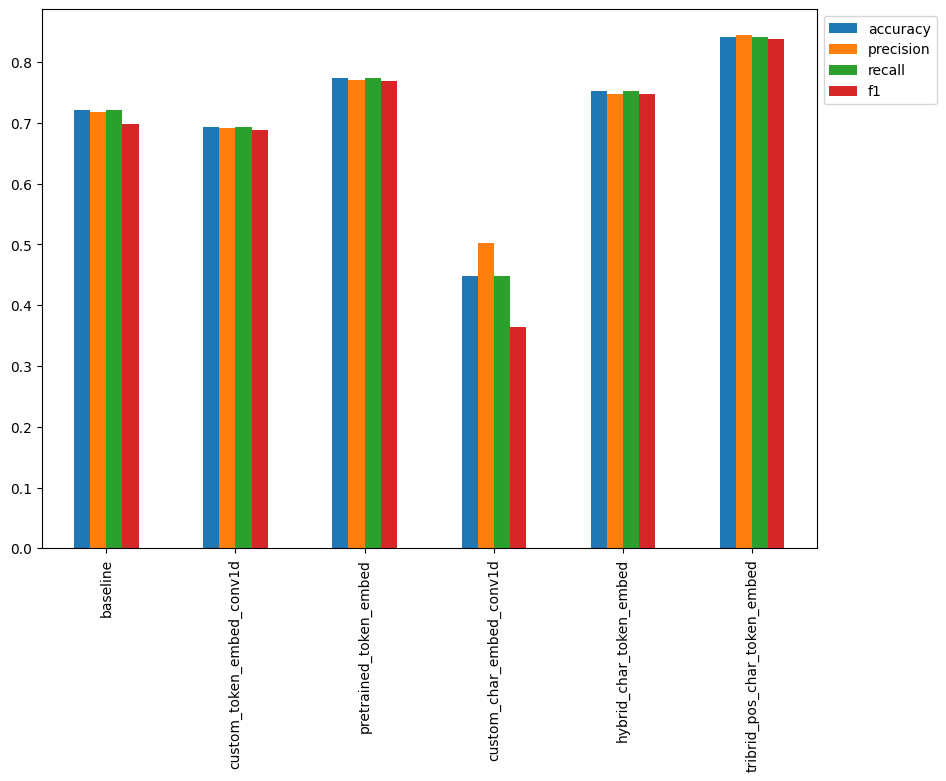

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('/content/drive/MyDrive/datasets/SkimLit/metrics/model_results.png');

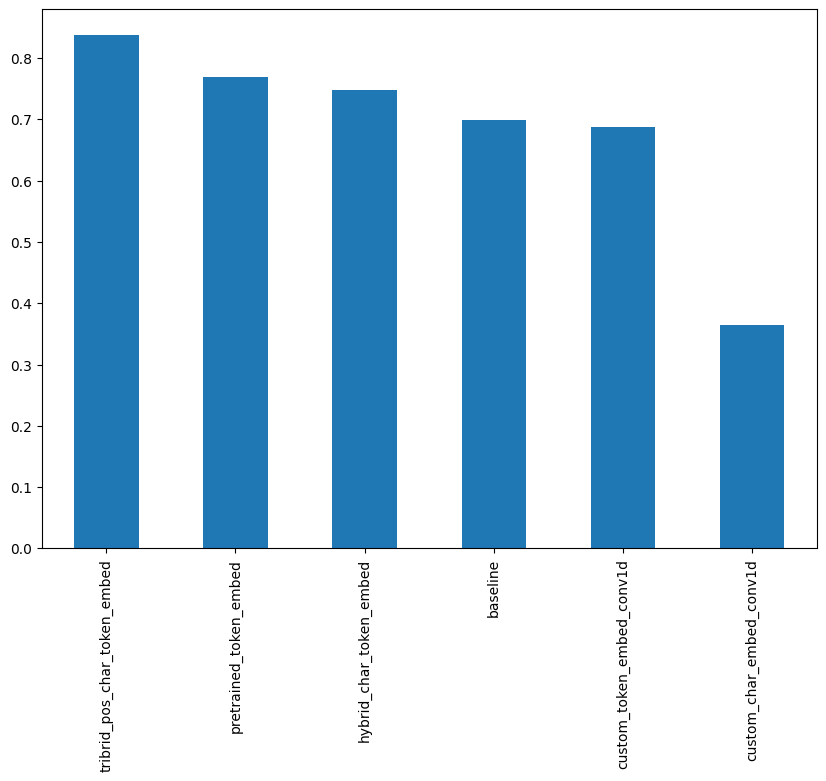

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))
plt.savefig('/content/drive/MyDrive/datasets/SkimLit/metrics/model_results_f1_score.png');

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./skimlit_experiment \
  --name "SkimLit App Model Experiments" \
  --description "Trying different embedding layers" \
  --one_shot # exits the uploader when upload has finished

2023-05-07 00:07:34.089636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/cR9GC4MPRKezgOQyHbIESQ/

[2023-05-07T00:07:40] Started scanning logdir.
[2023-05-07T00:07:48] Total uploaded: 150 scalars, 0 tensors, 7 binary objects (9.8 MB)
[2023-05-07T00:07:48] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/cR9GC4MPRKezgOQyHbIESQ/


The TensorBoard.dev experiment can be viewed here: https://tensorboard.dev/experiment/cR9GC4MPRKezgOQyHbIESQ/

## Find most Wrong

In [ ]:
%%time
# Get list of class names of test predictions
val_pred_classes = [label_encoder.classes_[pred] for pred in model_5_preds]

CPU times: user 9.86 s, sys: 32.2 ms, total: 9.9 s
Wall time: 10.1 s


In [ ]:
# Create prediction-enriched test dataframe
val_df["prediction"] = val_pred_classes # create column with test prediction class names
val_df["pred_prob"] = tf.reduce_max(model_5_pred_probs, axis=1).numpy() # get the maximum prediction probability
val_df["correct"] = val_df["prediction"] == val_df["target"] # create binary column for whether the prediction is right or not
val_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9,BACKGROUND,0.611729,True
1,BACKGROUND,it is not clear whether these patients would b...,1,9,BACKGROUND,0.648725,True
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9,BACKGROUND,0.370894,False
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9,METHODS,0.820174,True
4,METHODS,primary outcomes were improvement in quality o...,4,9,METHODS,0.853826,True
5,RESULTS,sixty-five patients were randomized .,5,9,METHODS,0.464150,False
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9,RESULTS,0.655006,True
7,RESULTS,fifty-six patients took the full @ months of m...,7,9,RESULTS,0.665651,True
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9,RESULTS,0.821816,True
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9,CONCLUSIONS,0.683668,True


In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = val_df[val_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
28193,RESULTS,primary outcome measures were symptom self-rat...,5,13,METHODS,0.944255,False
15769,RESULTS,dwellings in the itn+irs arm were sprayed with...,4,17,METHODS,0.942594,False
20408,RESULTS,"a double-blind , randomized , controlled trial...",2,17,METHODS,0.933087,False
29986,RESULTS,the primary outcome was days alive and out of ...,4,12,METHODS,0.928355,False
1027,RESULTS,participants were randomized to tadalafil @ mg...,4,14,METHODS,0.924627,False
...,...,...,...,...,...,...,...
29405,RESULTS,"before and after @ weeks , all subjects underw...",3,11,METHODS,0.847167,False
4812,CONCLUSIONS,"on intention-to-treat analysis , both the pkep...",11,18,RESULTS,0.847162,False
28115,OBJECTIVE,a randomized comparison of these @ systems has...,2,16,METHODS,0.847042,False
10035,RESULTS,unblinded randomisation occurred on a weekly b...,5,17,METHODS,0.847028,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: METHODS, Prob: 0.944254994392395, Line number: 5, Total lines: 13

Text:
primary outcome measures were symptom self-rating scales ( insomnia severity index -lsb- isi -rsb- and the montgomery sberg depression rating scale -lsb- madrs-s -rsb- ) , assessed before and after treatment with follow-up after @ and @ mo. .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9425941705703735, Line number: 4, Total lines: 17

Text:
dwellings in the itn+irs arm were sprayed with two rounds of bendiocarb in @ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9330865740776062, Line number: 2, Total lines: 17

Text:
a double-blind , randomized , controlled trial was conducted at @ sites in the united states .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9283552169799805, Line number: 4, Total lines: 12

Text:
the primary outcome was days alive and out of the hospital within @ days of surgery .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9246271848678589, Line number: 4, Tota

### Testing given abstract

In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")